In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [ ]:
import ast
import csv
import itertools
from itertools import product
import numpy as np
import pandas as pd

from loss_functions import *
from src.activation_functions import *
from src.batch_normalization import *
from src.data_preprocessing import *
from src.ensemble.cascade_correlation import CascadeCorrelation
from src.k_fold_cross_validation import *
from src.layer import *
from src.early_stopping import EarlyStopping
from src.neural_network import *
from src.optimizers import *
from src.random_search import *
from src.train_and_evaluate import Train
from src.utils import *

# from src.random_search import *

np.random.seed(0)

<!-- #### Data pre-processing for MONK Datasets  -->

In [150]:
MONK_NUM=3
X_train, y_train = load_data(MONK_NUM=MONK_NUM)
X_test, y_test = load_data(MONK_NUM=MONK_NUM, train=False)

one hot encoded data:  (122, 17)
one hot encoded data:  (432, 17)


In [151]:
X_train, X_val = train_test_split(X_train)
y_train, y_val = train_test_split(y_train)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [152]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))

Training set size: 97
Validation set size: 25


In [153]:
# Print the shape of the resulting datasets
for _ in [X_train, X_val, y_train, y_val]:
    print(f"the shape: ", _.shape)

the shape:  (97, 17)
the shape:  (25, 17)
the shape:  (97, 1)
the shape:  (25, 1)


In [ ]:
param_distributions = {
    'learning_rate': [1e-2, 3e-2, 7e-3],
    'l1': [1e-6, 1e-3, 1e-4],
    'l2': [1e-2, 1e-5, 1e-3],
    'dropout_rate': [0.3, 0.1, 0.0],
    'batch_size': [8, 32, 1000],
    'n_epochs': [150, 300],
    'hidden_size': [4, 6],
    'hidden_activation': [Activation_Sigmoid, Activation_ReLU, Activation_Leaky_ReLU,  Activation_Tanh],
    'batch_norm': [False, True],
    'weight_decay': [0, 1e-2, 2e-2],
    'n_h_layers': [1, 2, 3],
    'patience': [30, 50],
    'CC': [False],
    'weights_init': ['gaussian', 'gaussian_scaled', 'xavier', 'he', 'random'],
}

print(f"Number of possible combinations: {count_permutations(param_distributions)}")

Number of possible combinations: 933120


In [166]:
best_hyperparams, best_performance = random_search(X_train=X_train, y_train=y_train, param_distributions=param_distributions, n_iters=500, csv_path=f"monk{MONK_NUM}_top5res.csv")  # adjust n_iters as needed

print(best_hyperparams)

✅ Fold 1/5 | Validation Loss: 0.2501
✅ Fold 2/5 | Validation Loss: 0.2501
✅ Fold 3/5 | Validation Loss: 0.2501
✅ Fold 4/5 | Validation Loss: 0.2500
✅ Fold 5/5 | Validation Loss: 0.2499

📊 Manual K-Fold | Mean Validation Losses over 5 folds: 0.2500
✅ Fold 1/5 | Validation Loss: 0.0516
✅ Fold 2/5 | Validation Loss: 0.0814
✅ Fold 3/5 | Validation Loss: 0.0010
✅ Fold 4/5 | Validation Loss: 0.1113
✅ Fold 5/5 | Validation Loss: 0.0562

📊 Manual K-Fold | Mean Validation Losses over 5 folds: 0.0603
✅ Fold 1/5 | Validation Loss: 0.2505
✅ Fold 2/5 | Validation Loss: 0.2499
✅ Fold 3/5 | Validation Loss: 0.2488
✅ Fold 4/5 | Validation Loss: 0.2477
✅ Fold 5/5 | Validation Loss: 0.2500

📊 Manual K-Fold | Mean Validation Losses over 5 folds: 0.2494
✅ Fold 1/5 | Validation Loss: 0.2909
✅ Fold 2/5 | Validation Loss: 0.2459
✅ Fold 3/5 | Validation Loss: 0.2500
✅ Fold 4/5 | Validation Loss: 0.2454
✅ Fold 5/5 | Validation Loss: 0.2437

📊 Manual K-Fold | Mean Validation Losses over 5 folds: 0.2552
✅ Fold 1

In [167]:
print(best_hyperparams)

{'learning_rate': 0.03, 'l1': 0.001, 'l2': 0.001, 'dropout_rate': 0.1, 'batch_size': 32, 'n_epochs': 150, 'hidden_size': 4, 'hidden_activation': <class 'src.activation_functions.Activation_ReLU'>, 'batch_norm': False, 'weight_decay': 0.01, 'n_h_layers': 2, 'patience': 50, 'CC': False, 'weights_init': 'he', 'val_loss': np.float64(0.044901602882220365)}


GRID SEARCH

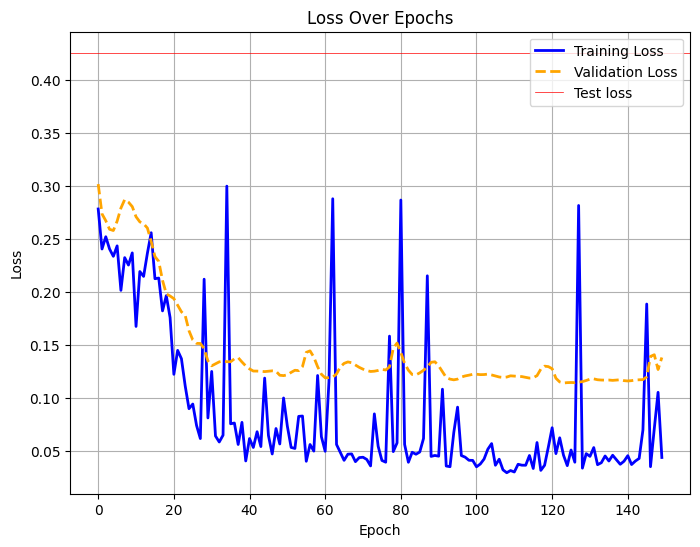

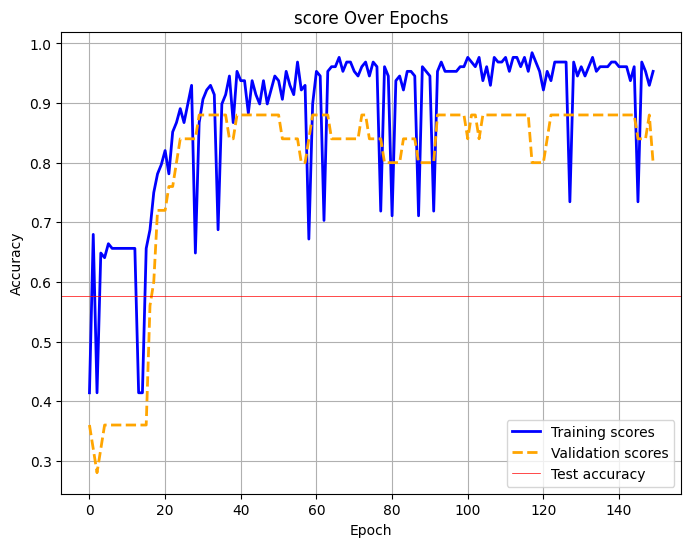

In [168]:
if best_hyperparams['CC']:
    model = CascadeCorrelation(input_size = 17, output_size= 1, activation=Activation_Leaky_ReLU, output_activation = Activation_Sigmoid)
else:
    model = NN(
        l1=best_hyperparams['l1'],
        l2=best_hyperparams['l2'],
        input_size=17,
        hidden_size=best_hyperparams['hidden_size'],
        output_size=1,
        hidden_activation=best_hyperparams['hidden_activation'],
        dropout_rate=best_hyperparams['dropout_rate'],
        use_batch_norm=best_hyperparams['batch_norm'],
        n_h_layers=best_hyperparams['n_h_layers']
    )

train = Train(best_hyperparams, model)
train.train_and_evaluate(X_train, y_train, X_val, y_val)
train.test(X_test, y_test)
train.plot(score=True)

In [169]:
print(train.train_losses, train.val_losses)

[np.float64(0.2781971038109117), np.float64(0.24039946265297418), np.float64(0.25197427787961313), np.float64(0.24042221517778395), np.float64(0.23349913209695417), np.float64(0.24336198172835694), np.float64(0.20136788673667752), np.float64(0.2322570879358886), np.float64(0.22524476117184816), np.float64(0.23672447093231913), np.float64(0.1673019747085247), np.float64(0.2191581957573786), np.float64(0.21454152919540453), np.float64(0.2363609891066169), np.float64(0.2557631491264815), np.float64(0.21236843989394075), np.float64(0.21299592266706122), np.float64(0.1819738311634352), np.float64(0.19639436934706134), np.float64(0.17567908833010026), np.float64(0.12210039151725753), np.float64(0.14468542943158547), np.float64(0.13685082782212654), np.float64(0.11105407154092195), np.float64(0.089632696766992), np.float64(0.09404647953153533), np.float64(0.07379001715152131), np.float64(0.06143324407682279), np.float64(0.21189999396899475), np.float64(0.08091773467378924), np.float64(0.12482

In [170]:
print(f"Test Accuracy: {train.test_score:.4f}")

Test Accuracy: 0.5764


In [171]:
class EnsembleNN:
    def __init__(self, n_models=5):
        self.models = []
        self.n_models = n_models
        self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
        

    def create_and_train_models(self, hyperparams):
        # Create and train multiple models with the same hyperparameters
        for i in range(self.n_models):
            model = NN(
                l1=hyperparams['l1'],
                l2=hyperparams['l2'],
                input_size=17,
                hidden_size=hyperparams['hidden_size'],
                output_size=1,
                hidden_activation=hyperparams['hidden_activation'],
                dropout_rate=hyperparams['dropout_rate'],
                use_batch_norm=hyperparams['batch_norm'],
                n_h_layers=hyperparams['n_h_layers']
            )
            print(f"Training model {i+1}/{self.n_models}")
            # Train model using existing train_and_evaluate function
            self.train = Train(hyperparams, model)
            model, val_accuracy = self.train.train_and_evaluate(
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
            )
            self.models.append(model)
            print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")

    def predict(self, X):
        """Make predictions using majority voting"""
        predictions = []
        for model in self.models:
            model.forward(X, training=False)
            self.loss_activation.forward(
                model.output, np.zeros((X.shape[0], 2)))  # Dummy y values
            pred = np.argmax(self.loss_activation.output, axis=1)
            predictions.append(pred)

        # Majority voting
        predictions = np.array(predictions)
        final_predictions = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(),
            axis=0,
            arr=predictions
        )
        return final_predictions

Training model 1/5
Model 1 validation accuracy: 0.8800
Training model 2/5
Model 2 validation accuracy: 0.8800
Training model 3/5
Model 3 validation accuracy: 0.8400
Training model 4/5
Model 4 validation accuracy: 0.8000
Training model 5/5
Model 5 validation accuracy: 0.8800
Ensemble Test Accuracy: 0.5069


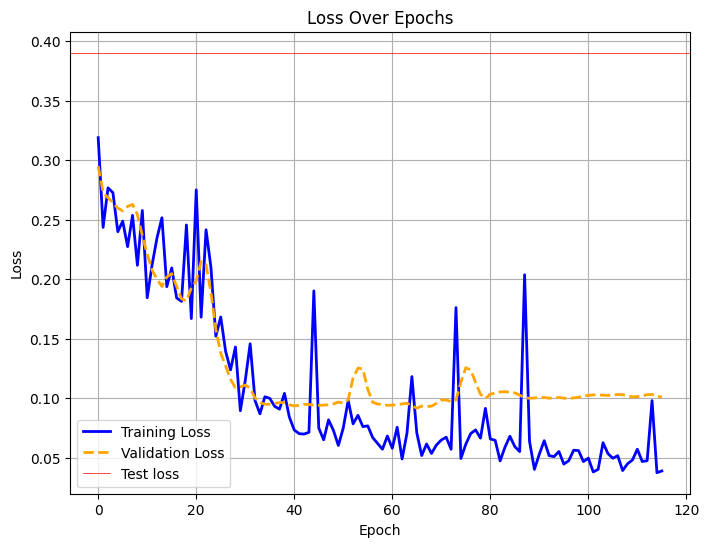

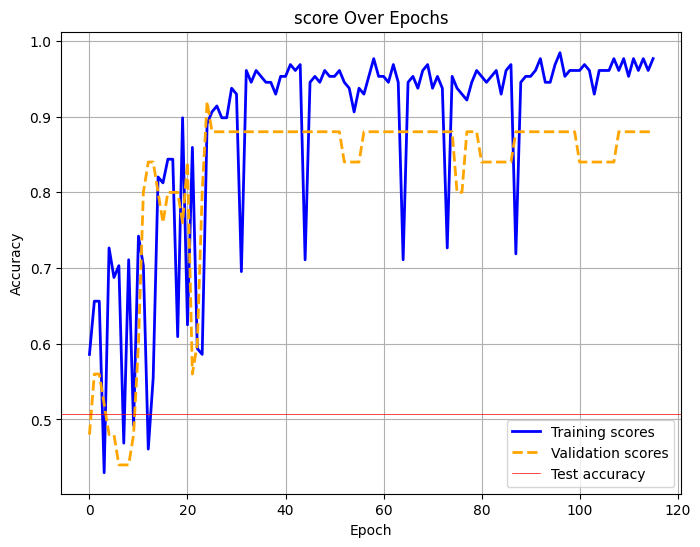

In [172]:
ensemble = EnsembleNN(n_models=5)

ensemble.create_and_train_models(best_hyperparams)

_ , test_accuracy = ensemble.train.test(X_test, y_test)

print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")

ensemble.train.plot(score=True)